In [1]:
import copy
import pickle
import sys
from collections import defaultdict
from pprint import pprint

import numpy as np
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW

from src.cfd import CFD
from src.dataset import ExpandedDataset
from src.gauss_hist import plot_gauss_hist
from src.utils import save_plt
from src.waveform_data import EventData, WaveformData

PWD = '../../..'
sys.path.append(PWD)

In [2]:
N_JOBS = 16

INPUT_PATH = PWD + '/data/converted_input/dataset_s45.pkl'
DATASET_PATH = PWD + '/data/dataset/dataset_s45.pkl'
# EXPANDED_DATASET_PATH = PWD + '/data/dataset/dataset_exp.pkl'
#
THRESHOLD_PAIR_DIFF_STD_RESULTS_PATH = PWD + '/data/tmp/produce_dataset/threshold_pair_diff_std_results_s45.pkl'
# IMAGES_DIR = PWD + '/data/images/produce_dataset/'

CFD_AVG_KEY = 't_cfd_avg'

SERIES_LEN = 24
CFD_N_BASELINE = 6

# Load input

In [3]:
# load the dataset
with open(INPUT_PATH, 'rb') as file:
    original_dataset = pickle.load(file)

In [4]:
print(original_dataset[13050])

{'plane 0': {'channel 2': 't0: -2.835446357727051'}, 'plane 1': {'channel 2': 't0: -1.7493606805801392'}, 'plane 3': {'channel 2': 't0: -1.770323634147644'}}


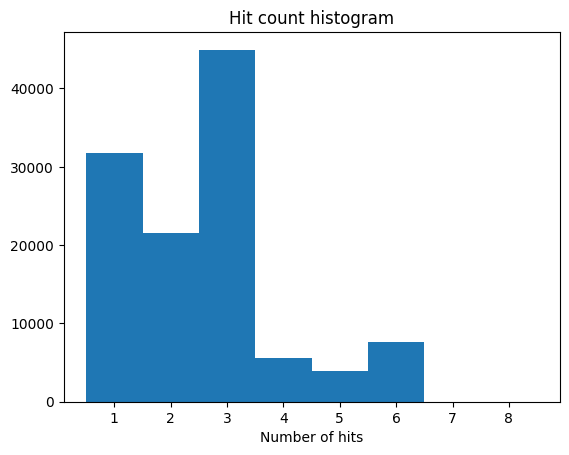

In [5]:
def plot_hit_count_histogram(dataset, title='Hit count histogram'):
    hit_count_histogram = [event_data.get_hit_count() for event_data in dataset.values()]

    plt.hist(hit_count_histogram, bins=range(1, 8 + 2), align='left')
    plt.title(title)
    plt.xlabel('Number of hits')


plot_hit_count_histogram(original_dataset)
plt.show()

# Utils

In [6]:
def plot_channel_data(data_dict, suptitle, xlabel, thresholds=None, bins=50, bin_width=None, xrange=None, show=True,
                      font_size=8.5, figsize=(16, 6.5), hist_max=None, ymax=None, xticks=None, xticks_list=None):
    plt.figure(figsize=figsize)
    plt.rc('font', size=font_size)
    for i, ((plane, channel), data) in enumerate(sorted(data_dict.items())):
        if thresholds is not None:
            t = thresholds[(plane, channel)]
            if bin_width is not None:
                bins = np.arange(t[0], t[1] + 0.9999 * bin_width, bin_width)

        plt.subplot(2, 4, i + 1)
        plt.hist(data, bins=bins, range=xrange)
        plt.ylim(top=hist_max)
        if thresholds is not None:
            plt.axvline(t[0], c='red')
            plt.axvline(t[1], c='red')
        plt.title(f'plane: {plane}, channel: {channel}')
        plt.xlabel(xlabel)
        if ymax:
            plt.ylim(top=ymax)
        if xticks is not None:
            plt.xticks(xticks)
        if xticks_list is not None:
            plt.xticks(xticks_list[i])

    plt.suptitle(suptitle)
    plt.tight_layout()
    if show:
        plt.show()

# Remove saturated and noisy events

In [7]:
channel_vmax_thresholds = {
    (0, 2): (0.28, 0.7),
    (0, 11): (1.01, 1.02),
    (1, 2): (0.34, 0.72),
    (1, 11): (1.01, 1.02),
    # (2, 2): (0.34, 0.70),
    # (2, 11): (0.34, 0.70),
    (3, 2): (0.32, 0.70),
    (3, 11): (1.01, 1.02)
}

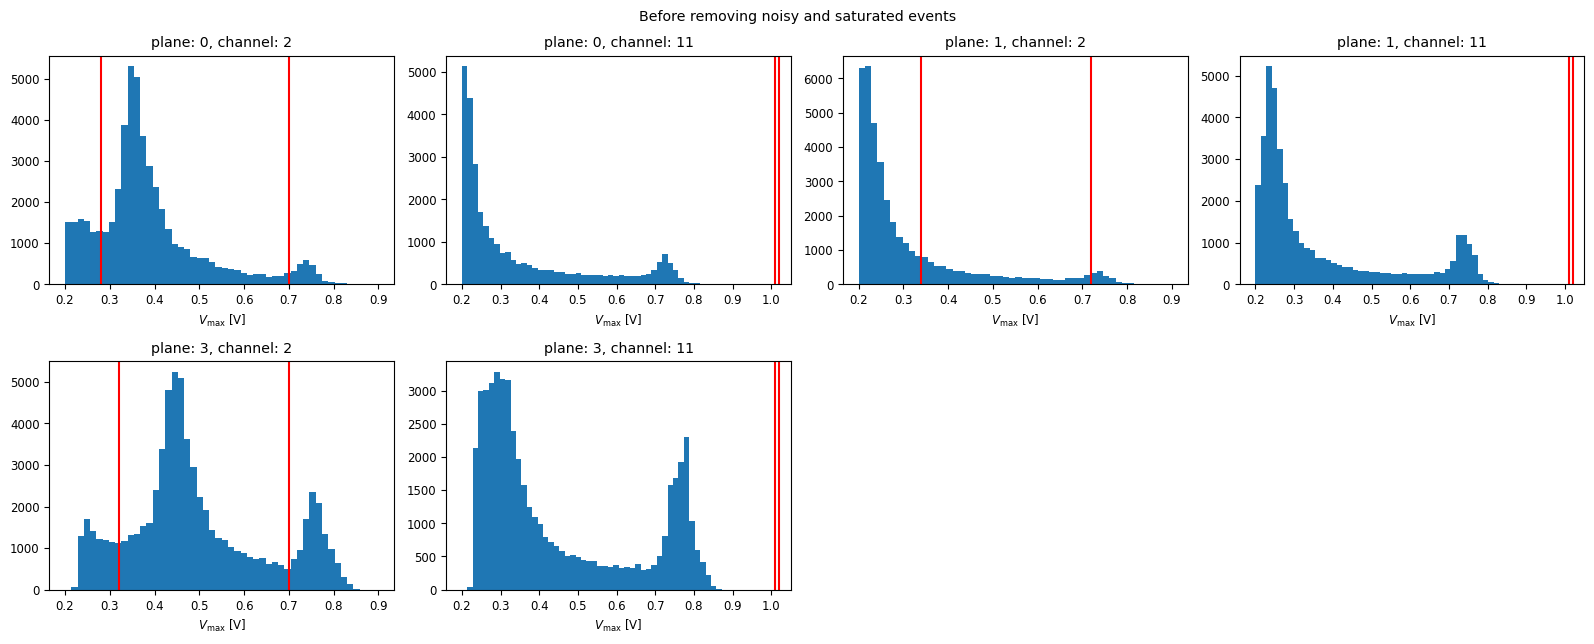

In [8]:
vmax_histograms = defaultdict(list)
for event, event_data in original_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            vmax_histograms[(plane, channel)].append(np.max(wav_data.series[1]))

plot_channel_data(vmax_histograms, 'Before removing noisy and saturated events', '$V_{\mathrm{max}}$ [V]',
                  channel_vmax_thresholds, xrange=(0.2, 0.9))

In [9]:
plot_channel_data(vmax_histograms, None, '$V_{\mathrm{max}}$ [V]', channel_vmax_thresholds, font_size=12.2, show=False,
                  figsize=(12, 5), xticks=np.arange(0.2, 1.01, 0.2))
# save_plt(IMAGES_DIR + '/filtering_noise_saturation.pdf')
plt.close()

In [10]:
vmax_dataset = copy.deepcopy(original_dataset)

for event, event_data in vmax_dataset.items():
    for plane, plane_data in list(event_data.planes.items()):
        for channel, wav_data in list(plane_data.items()):
            thresholds = channel_vmax_thresholds[(plane, channel)]
            if not thresholds[0] <= np.max(wav_data.series[1]) <= thresholds[1]:
                event_data.remove_channel(plane, channel)

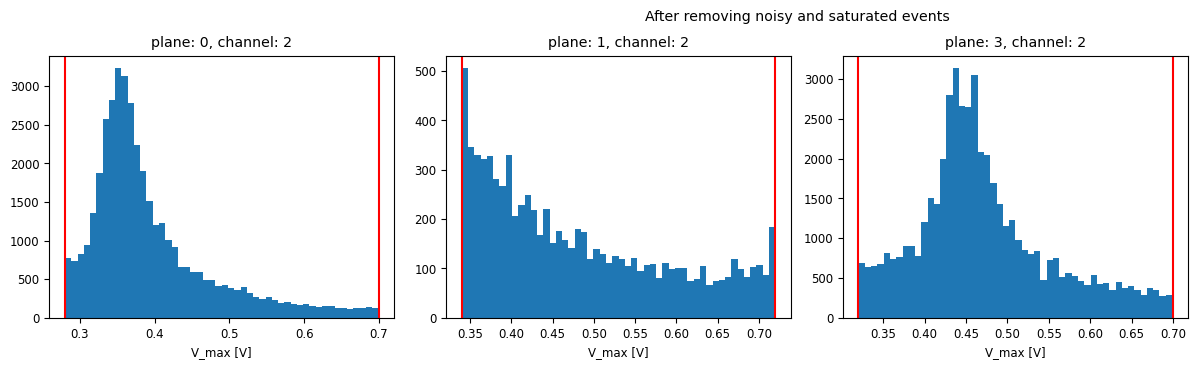

In [11]:
vmax_histograms_2 = defaultdict(list)
for event, event_data in vmax_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            vmax_histograms_2[(plane, channel)].append(np.max(wav_data.series[1]))

plot_channel_data(vmax_histograms_2, 'After removing noisy and saturated events', 'V_max [V]', channel_vmax_thresholds)

# t0 histograms

In [12]:
# 8 1/3
channel_t0_thresholds = {
    (0, 2): (-4, -1),
    # (0, 11): (2, 2),
    (1, 2): (-3, -1),
    # (1, 11): (-2.5, 1.5),
    # (2, 2): (-0.5, 3.5),
    # (2, 11): (-2, 2),
    (3, 2): (-3, 0),
    # (3, 11): (0, 4)
}

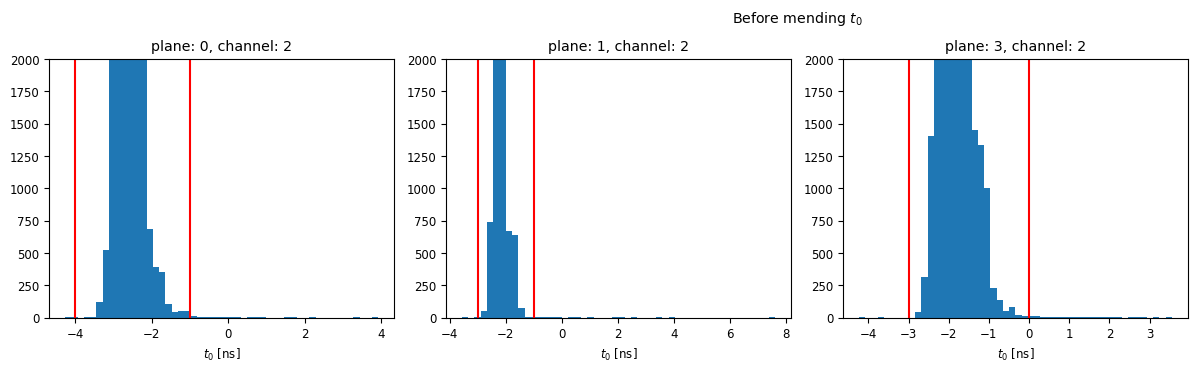

In [13]:
t0_dict = defaultdict(list)
for event_data in vmax_dataset.values():
    for plane, channel, wav_data in event_data.get_all_waveforms():
        t0_dict[(plane, channel)].append(wav_data.t0)

plot_channel_data(t0_dict, 'Before mending $t_0$', '$t_0$ [ns]', channel_t0_thresholds, bins=50, hist_max=2000)

In [14]:
plot_channel_data(t0_dict, None, '$t_0$ [ns]', channel_t0_thresholds, bins=50, hist_max=1000, font_size=12.2, show=False,
                  figsize=(12, 5), xticks_list=[np.arange(-10, 6, 3)] + [np.arange(-8, 5, 2)] * 5)
# save_plt(IMAGES_DIR + '/t0_filtering.pdf')
plt.close()

In [15]:
t0_dataset = copy.deepcopy(vmax_dataset)

for event, event_data in t0_dataset.items():
    for plane, plane_data in list(event_data.planes.items()):
        for channel, wav_data in list(plane_data.items()):
            thresholds = channel_t0_thresholds[(plane, channel)]
            if not thresholds[0] <= wav_data.t0 <= thresholds[1]:
                event_data.remove_channel(plane, channel)

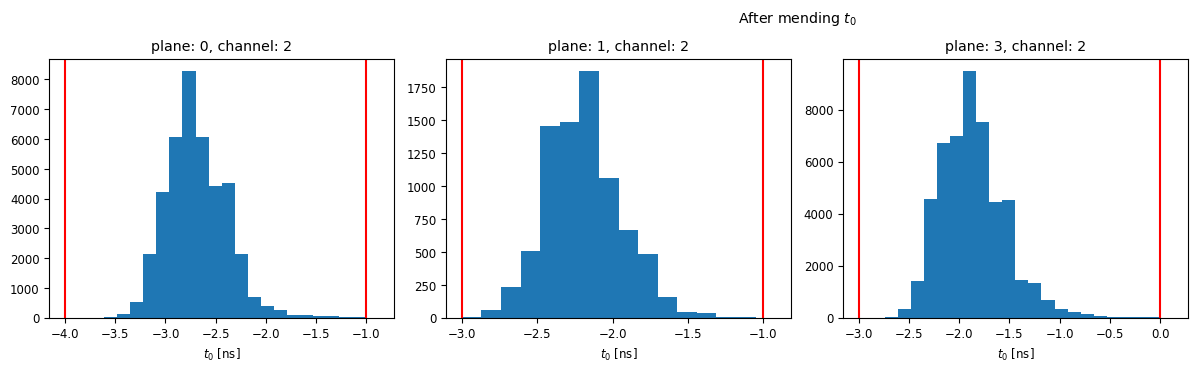

In [16]:
t0_dict = defaultdict(list)
for event_data in t0_dataset.values():
    for plane, channel, wav_data in event_data.get_all_waveforms():
        t0_dict[(plane, channel)].append(wav_data.t0)

plot_channel_data(t0_dict, 'After mending $t_0$', '$t_0$ [ns]', channel_t0_thresholds,
                  bin_width=0.129955)  # one bin around 1 / 7.695 ns = 0.129955 ns

# Find the optimal CFD threshold

## Minimum threshold filtering out noise

In [17]:
baseline_samples = []
for event, event_data in t0_dataset.items():
    for p, ch, wav_data in event_data.get_all_waveforms():
        wav = wav_data.series[1].copy()
        wav -= np.average(wav[:CFD_N_BASELINE])
        wav /= np.max(wav)
        baseline_samples.extend(wav[:6])

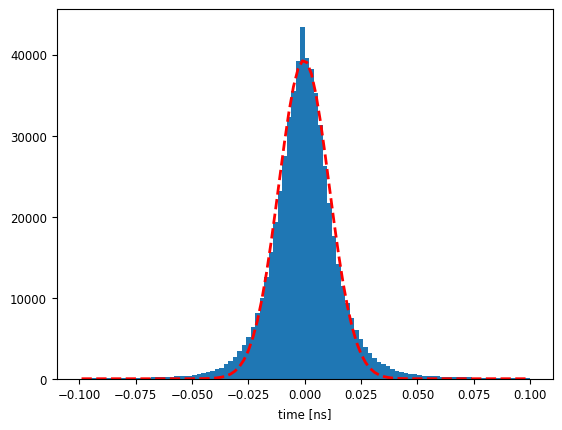

Gaussian std:, 0.011, stat std: 0.017


In [18]:
_, baseline_gauss_std, _, _ = plot_gauss_hist(np.array(baseline_samples), hist_range=(-0.1, 0.1))
baseline_stat_std = np.std(np.array(baseline_samples))
print(f'Gaussian std:, {baseline_gauss_std:0.3f}, stat std: {baseline_stat_std:0.3f}')

In [19]:
min_cfd_threshold = np.round(5 * baseline_gauss_std, 2)
print(f'MINIMUM CFD THRESHOLD:, {min_cfd_threshold}')

MINIMUM CFD THRESHOLD:, 0.06


## Optimal threshold


In [20]:
def calculate_t_cfds(dataset: np.ndarray, cfd: CFD, copy_dataset=True):
    if copy_dataset:
        dataset = copy.deepcopy(dataset)
    for event, event_data in dataset.items():
        for plane, plane_data in list(event_data.planes.items()):
            for channel, wav_data in list(plane_data.items()):
                t = cfd.predict_single(wav_data.series[0], wav_data.series[1])
                if t is None:  # Remove the events where CFD cannot be calculated
                    event_data.remove_channel(plane, channel)
                else:
                    wav_data.t_cfd = t
    return dataset


def find_channel_cfd_averages(dataset: np.ndarray):
    cfd_histograms = defaultdict(list)
    for event, event_data in dataset.items():
        for plane, plane_data in event_data.planes.items():
            for channel, wav_data in plane_data.items():
                cfd_histograms[(plane, channel)].append(wav_data.t_cfd + wav_data.t0)

    channel_cfd_averages = {}
    for (plane, channel), cfds in sorted(cfd_histograms.items()):
        channel_cfd_averages[(plane, channel)] = np.average(cfds)

    return channel_cfd_averages, cfd_histograms

In [21]:
def compute_threshold_diff_stds(threshold):
    print(f'Processing threshold={threshold:0.2f}...')
    cfd = CFD(n_baseline=CFD_N_BASELINE, threshold=threshold)
    dataset = calculate_t_cfds(t0_dataset, cfd, copy_dataset=False)
    channel_cfd_averages, _ = find_channel_cfd_averages(dataset)

    # Find cfd diffs per channel pair
    cfd_diffs = defaultdict(list)
    included_pairs = defaultdict(int)
    for event, event_data in list(dataset.items()):
        event_waveforms = list(event_data.get_all_waveforms())
        for i, (p1, ch1, wav1) in enumerate(event_waveforms):
            for p2, ch2, wav2 in event_waveforms[i + 1:]:
                if wav1.t_cfd is not None and wav2.t_cfd is not None:
                    key = tuple(sorted([(p1, ch1), (p2, ch2)]))
                    t1 = wav1.t_cfd + wav1.t0 - channel_cfd_averages[(p1, ch1)]
                    t2 = wav2.t_cfd + wav2.t0 - channel_cfd_averages[(p2, ch2)]
                    cfd_diffs[key].append(t2 - t1)
                    included_pairs[key] += 1

    # Compute per channel pair
    cfd_diff_stds = {key: np.std(diffs) for key, diffs in cfd_diffs.items()}

    print(f'Finished processing threshold={threshold:0.2f}')
    return threshold, cfd_diff_stds, included_pairs

In [22]:
# run and save results
thresholds = np.arange(0.06, 0.28, 0.01)
threshold_diff_stds_results = Parallel(n_jobs=N_JOBS)(
    delayed(compute_threshold_diff_stds)(threshold) for threshold in thresholds)

with open(THRESHOLD_PAIR_DIFF_STD_RESULTS_PATH, 'wb') as file:
    pickle.dump(threshold_diff_stds_results, file)

In [23]:
# load and process the results
with open(THRESHOLD_PAIR_DIFF_STD_RESULTS_PATH, 'rb') as file:
    threshold_diff_stds_results = pickle.load(file)

average_stds, std_stds, included_events, max_diff_stds = {}, {}, {}, {}
for threshold_stds in threshold_diff_stds_results:
    threshold = threshold_stds[0]

    keys = threshold_stds[1].keys()
    n_events = [threshold_stds[2][key] for key in keys]
    stds = [threshold_stds[1][key] for key in keys]
    weighted_stats = DescrStatsW(stds, weights=n_events)
    # weighted_stats = DescrStatsW(stds)

    average_stds[threshold] = weighted_stats.mean
    std_stds[threshold] = weighted_stats.std
    included_events[threshold] = sum(n_events)
    max_diff_stds[threshold] = max(stds)

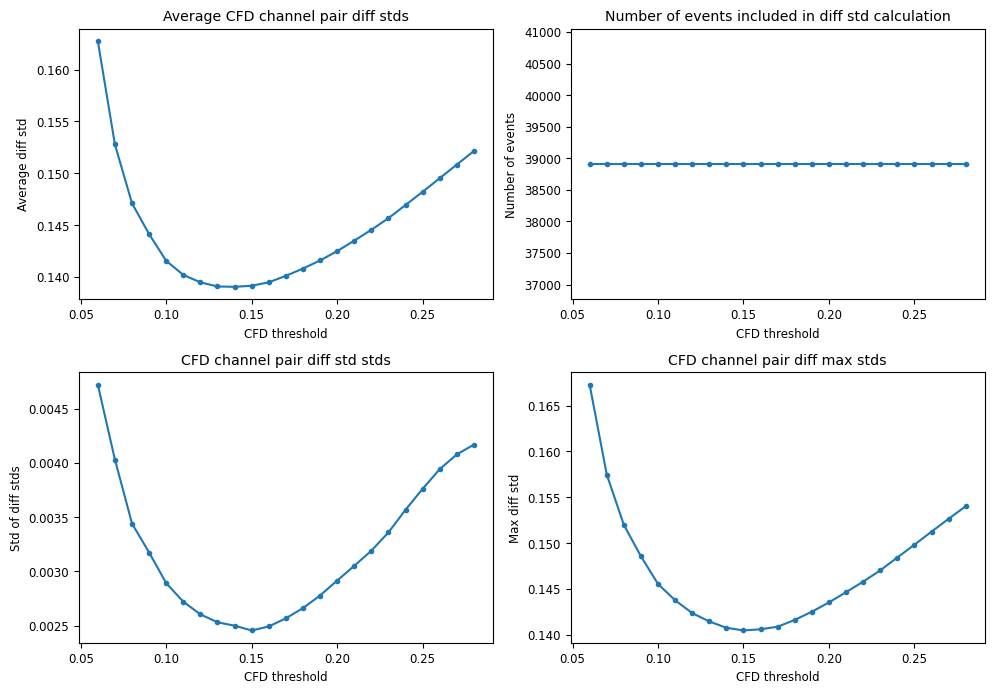

In [24]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 2, 1)
plt.plot(average_stds.keys(), average_stds.values(), marker='.')
plt.title('Average CFD channel pair diff stds')
plt.xlabel('CFD threshold')
plt.ylabel('Average diff std')

plt.subplot(2, 2, 2)
plt.plot(included_events.keys(), included_events.values(), marker='.')
plt.title('Number of events included in diff std calculation')
plt.xlabel('CFD threshold')
plt.ylabel('Number of events')

plt.subplot(2, 2, 3)
plt.plot(std_stds.keys(), std_stds.values(), marker='.')
plt.title('CFD channel pair diff std stds')
plt.xlabel('CFD threshold')
plt.ylabel('Std of diff stds')

plt.subplot(2, 2, 4)
plt.plot(max_diff_stds.keys(), max_diff_stds.values(), marker='.')
plt.title('CFD channel pair diff max stds')
plt.xlabel('CFD threshold')
plt.ylabel('Max diff std')

plt.tight_layout()
plt.show()

In [25]:
plt.rc('font', size=19)
plt.figure(figsize=(8, 5.5))
plt.plot(average_stds.keys(), average_stds.values(), marker='.')
plt.xlabel('CFD threshold')
plt.ylabel('Average difference std')
plt.grid()
plt.tight_layout()
plt.xticks(np.arange(0.12, 0.3, 0.03))
# save_plt(IMAGES_DIR + 'cfd_avg_diff_std.pdf')
plt.close()

In [26]:
plt.rc('font', size=19)
plt.figure(figsize=(8, 5.5))
plt.plot(max_diff_stds.keys(), max_diff_stds.values(), marker='.')
plt.xlabel('CFD threshold')
plt.ylabel('Max difference std')
plt.grid()
plt.tight_layout()
plt.xticks(np.arange(0.12, 0.3, 0.03))
# save_plt(IMAGES_DIR + 'cfd_max_diff_std.pdf')
plt.close()

In [27]:
optimal_cfd_threshold = list(max_diff_stds.keys())[np.argmin(list(max_diff_stds.values()))]
optimal_cfd_threshold = max(optimal_cfd_threshold, min_cfd_threshold)
print(f'Optimal CFD threshold: {optimal_cfd_threshold:0.3f}')

Optimal CFD threshold: 0.150


# Calculate CFD timestamps and adjust t0

In [28]:
# optimal_cfd_threshold = 0.3

In [29]:
cfd_dataset = copy.deepcopy(t0_dataset)
cfd_avg_shift_applied = False

cfd = CFD(n_baseline=CFD_N_BASELINE, threshold=optimal_cfd_threshold)
for event, event_data in cfd_dataset.items():
    for plane, plane_data in list(event_data.planes.items()):
        for channel, wav_data in list(plane_data.items()):
            t = cfd.predict_single(wav_data.series[0], wav_data.series[1])
            if t is None:  # Remove the events where CFD cannot be calculated
                event_data.remove_channel(plane, channel)
            else:
                wav_data.t_cfd = t

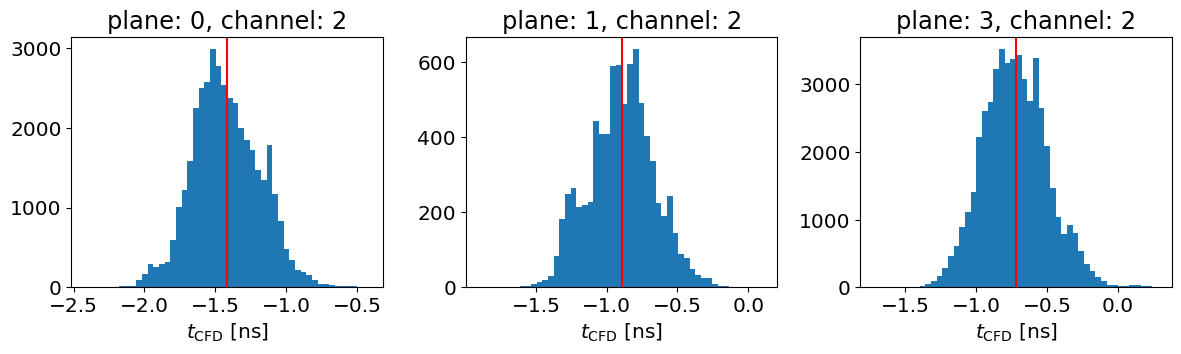

In [30]:
cfd_histograms = defaultdict(list)
for event, event_data in cfd_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            cfd_histograms[(plane, channel)].append(wav_data.t_cfd + wav_data.t0)

channel_cfd_averages = {}
for (plane, channel), cfds in sorted(cfd_histograms.items()):
    channel_cfd_averages[(plane, channel)] = np.average(cfds)

plt.figure(figsize=(16, 6.5))
plt.rc('font', size=14.5)
for i, ((plane, channel), cfds) in enumerate(sorted(cfd_histograms.items())):
    cfd_avg = channel_cfd_averages[(plane, channel)]
    plt.subplot(2, 4, i + 1)
    plt.hist(cfds, bins=50, range=(cfd_avg - 1, cfd_avg + 1))
    plt.axvline(cfd_avg, c='red')
    # plt.title(f'({plane}, {channel}); $t_{{\\mathrm{{CFD}}}}$ + $t_0$ avg: {cfd_avg:0.2f} ns')
    plt.title(f'plane: {plane}, channel: {channel}')
    plt.xlabel('$t_{\mathrm{CFD}}$ [ns]')

plt.tight_layout()
# save_plt(IMAGES_DIR + 'adjusting_t0.pdf')
plt.show()

In [31]:
if not cfd_avg_shift_applied:
    for event, event_data in cfd_dataset.items():
        for plane, plane_data in event_data.planes.items():
            for channel, wav_data in plane_data.items():
                wav_data.t0 -= channel_cfd_averages[(plane, channel)]
                pass

cfd_avg_shift_applied = True

# Take only interesting events

In [32]:
plane_count = 3
hit_count = 3

In [33]:
interesting_dataset = cfd_dataset = copy.deepcopy(cfd_dataset)

for event, event_data in list(interesting_dataset.items()):
    if event_data.get_plane_count() != plane_count or event_data.get_hit_count() != hit_count:
        del interesting_dataset[event]

# Calculate CFD event averages

In [34]:
def compute_true_t_cfd(event_data: EventData, wav_data: WaveformData):
    # use only timestamps from other channels
    return ((event_data.get_hit_count() * event_data.t_cfd_average) - (wav_data.t_cfd + wav_data.t0)) / (
            event_data.get_hit_count() - 1) - wav_data.t0


stds = []
for event, event_data in list(interesting_dataset.items()):
    cfds = [wav_data.t_cfd + wav_data.t0 for _, _, wav_data in event_data.get_all_waveforms()]
    # cfds = [wav_data.t_cfd for _, _, wav_data in event_data.get_all_waveforms()]
    if not cfds:  # Remove event if empty after the selection
        del interesting_dataset[event]
    else:
        event_data.t_cfd_average = np.average(cfds)
        for plane, plane_data in event_data.planes.items():
            for channel, wav_data in plane_data.items():
                wav_data.true_t_cfd = compute_true_t_cfd(event_data, wav_data)

        if len(cfds) >= 2:
            stds.append(np.std(cfds))

# Eliminate events with outlying true timestamp values

In [35]:
THRESHOLD_MIN = 0.5
THRESHOLD_MAX = 2.0

In [36]:
true_filtered_dataset = copy.deepcopy(interesting_dataset)


def _are_all_within_thresholds(plane_data):
    for channel, wav_data in plane_data.items():
        if wav_data.true_t_cfd < THRESHOLD_MIN or wav_data.true_t_cfd > THRESHOLD_MAX:
            return False
    return True


deleted_count = 0
for event, event_data in list(true_filtered_dataset.items()):
    for plane, plane_data in event_data.planes.items():
        if not _are_all_within_thresholds(plane_data):
            deleted_count += 1
            del true_filtered_dataset[event]
            break

deleted_count

15

# CFD differences

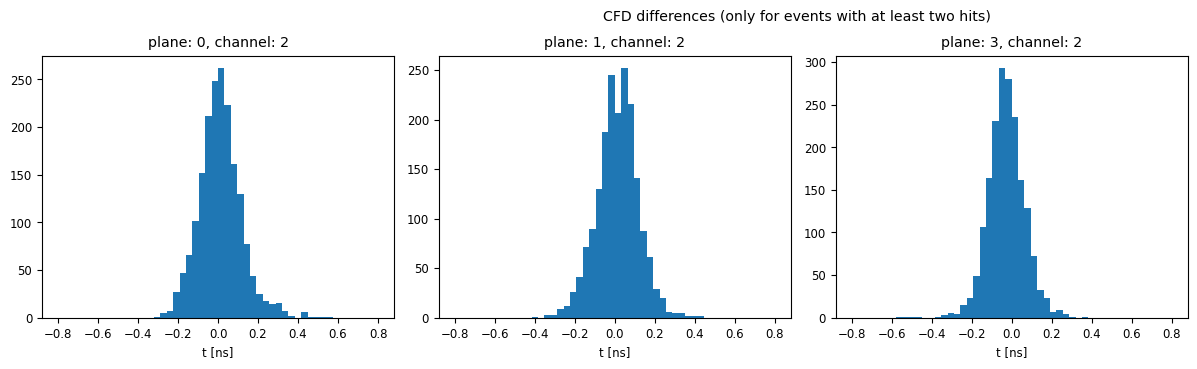

In [37]:
cfd_differences = defaultdict(list)
for event, event_data in true_filtered_dataset.items():
    if event_data.get_hit_count() >= 2:
        for plane, plane_data in event_data.planes.items():
            for channel, wav_data in plane_data.items():
                cfd_differences[(plane, channel)].append(wav_data.t_cfd - wav_data.true_t_cfd)

plot_channel_data(cfd_differences, 'CFD differences (only for events with at least two hits)', 't [ns]',
                  xrange=(-0.8, 0.8))

In [38]:
plot_channel_data(cfd_differences, None, 'time [ns]', xrange=(-0.8, 0.8), font_size=12.5, show=False, figsize=(12, 5))
# save_plt(IMAGES_DIR + 'true_cfd_differences.pdf')
plt.close()

# Examples

In [39]:
dataset = true_filtered_dataset

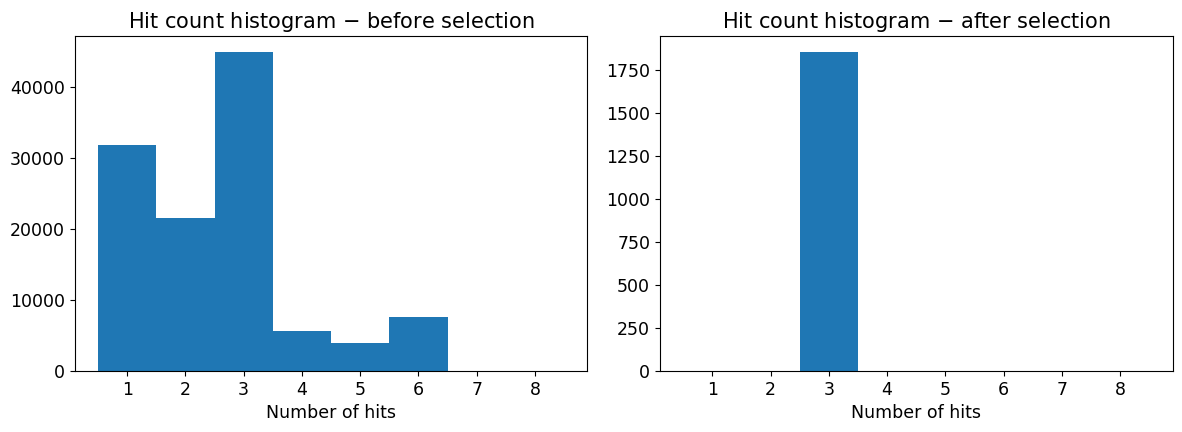

In [40]:
plt.figure(figsize=(12, 4.5))

plt.subplot(1, 2, 1)
plot_hit_count_histogram(original_dataset, title='Hit count histogram $-$ before selection')

plt.subplot(1, 2, 2)
plot_hit_count_histogram(dataset, title='Hit count histogram $-$ after selection')

plt.tight_layout()
plt.show()

In [41]:
plt.figure(figsize=(12, 4.5))
plt.rc('font', size=17)

plt.subplot(1, 2, 1)
plot_hit_count_histogram(original_dataset, title=None)

plt.subplot(1, 2, 2)
plot_hit_count_histogram(dataset, title=None)

plt.tight_layout()
# save_plt(IMAGES_DIR + 'hit_count_filtering.pdf')
plt.close()

In [42]:
events_to_view = list(dataset.keys())[:8]

for event, event_data in dataset.items():
    if event_data.get_plane_count() == 3 and event_data.get_hit_count() == 3 and len(
            set([channel for _, channel, _ in event_data.get_all_waveforms()])) == 2:
        events_to_view.append(event)
    if len(events_to_view) == 12:
        break

events_to_view

[101374, 120634, 251554, 379801, 480124, 753645, 761210, 818681]

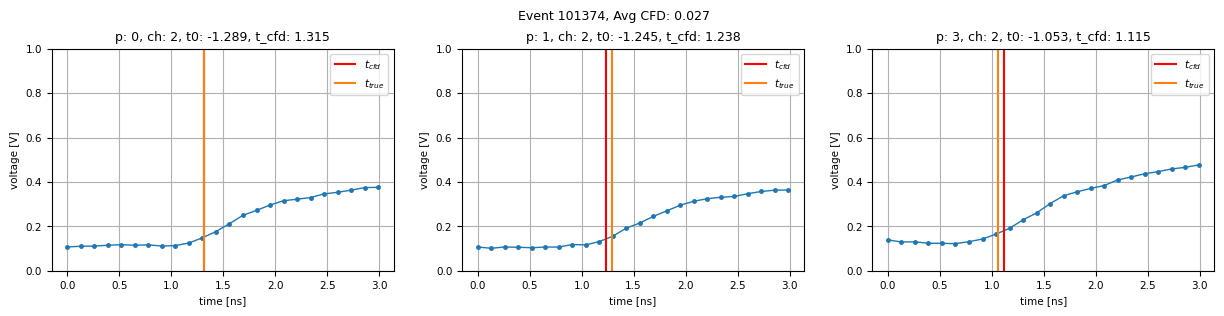

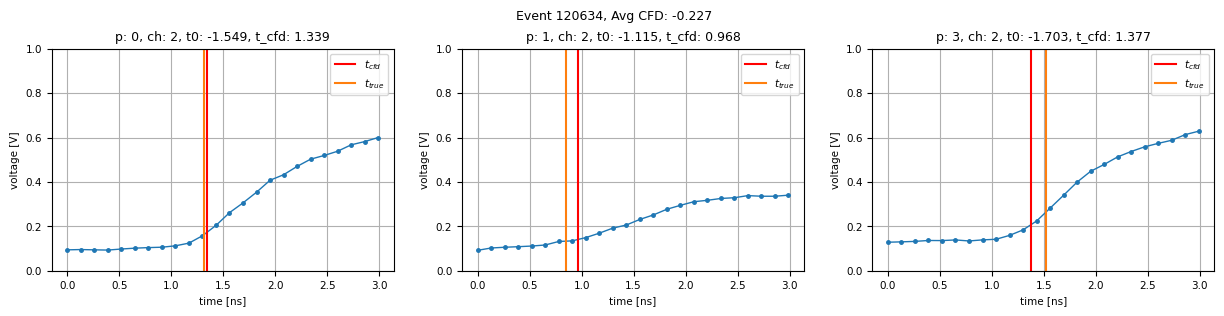

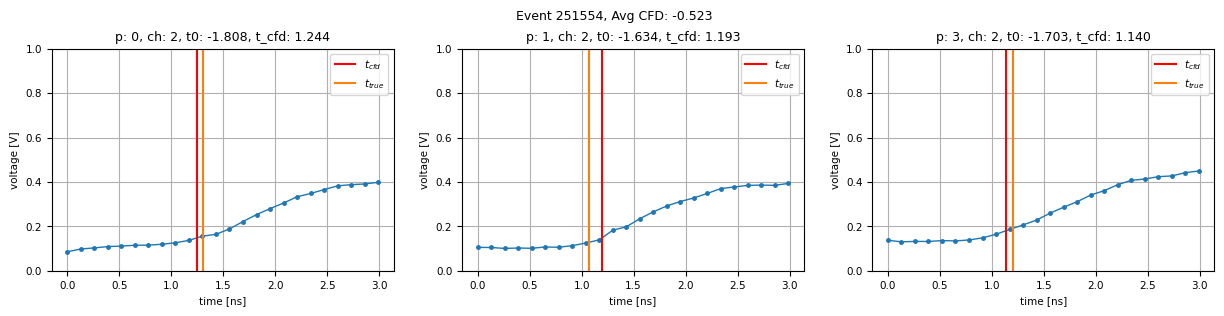

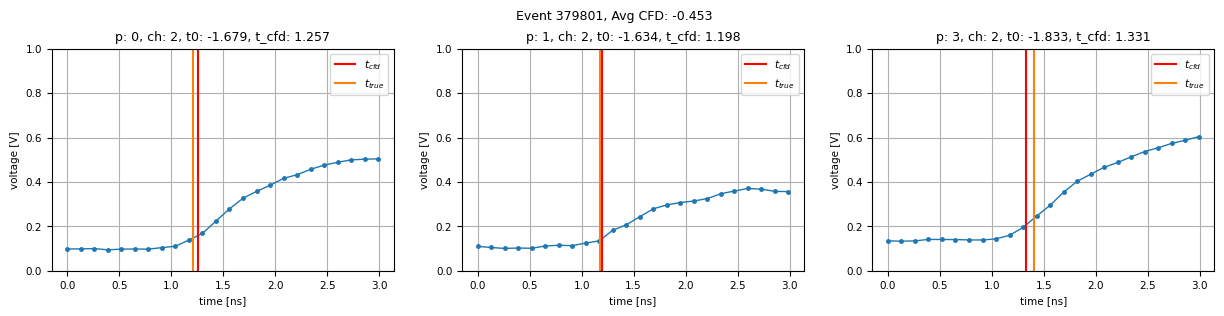

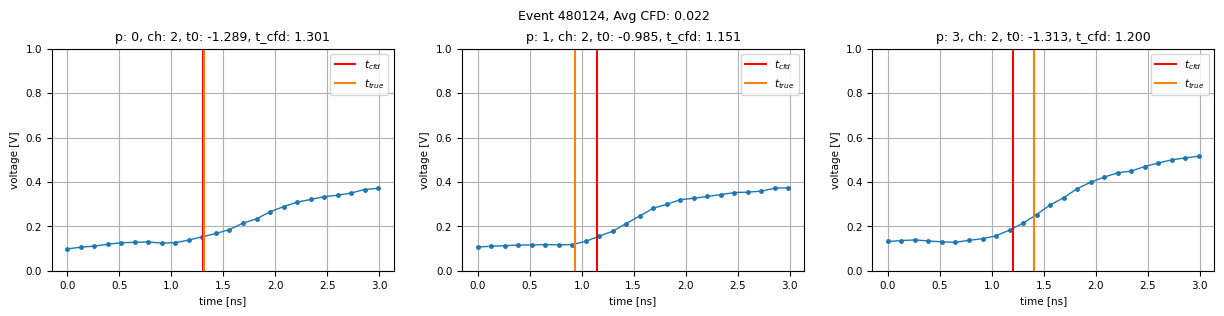

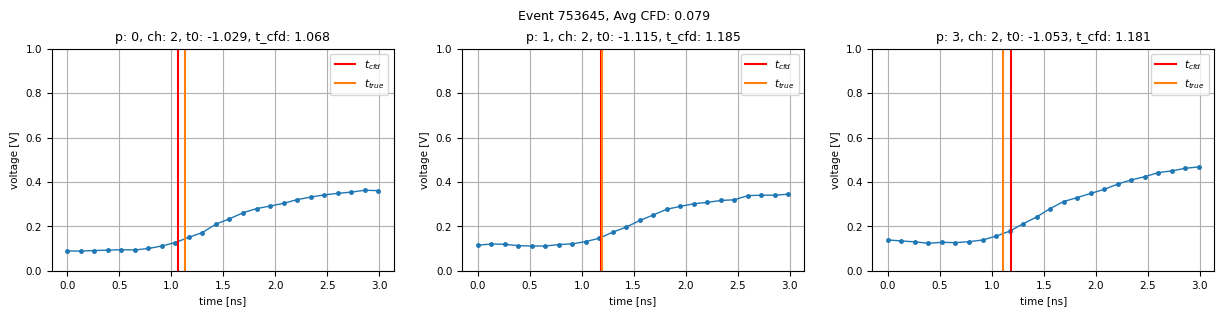

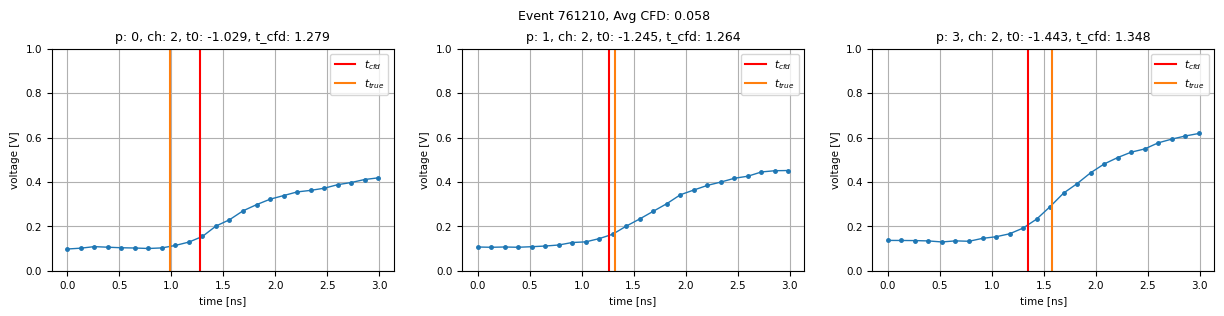

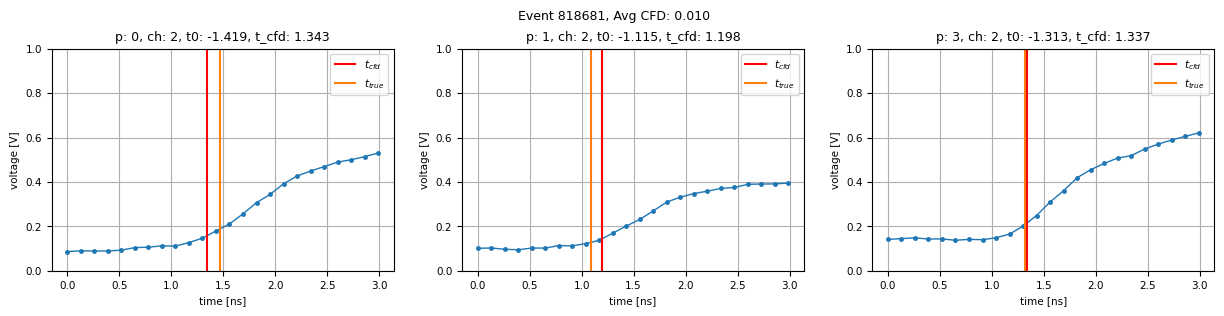

In [43]:
for event in events_to_view:
    plt.figure(figsize=(15, 3))
    plt.rc('font', size=7.5)

    for i, (plane, channel, wav_data) in enumerate(dataset[event].get_all_waveforms()):
        plt.subplot(1, 3, i + 1)
        plt.plot(wav_data.series[0], wav_data.series[1], marker='.', linewidth=1, markersize=5)
        if wav_data.t_cfd is not None:
            plt.axvline(wav_data.t_cfd, c='red', label='$t_{cfd}$')
        plt.axvline(wav_data.true_t_cfd, c='tab:orange', label='$t_{true}$')
        plt.ylim(0, 1)
        t_cfd_str = f'{wav_data.t_cfd:0.3f}' if wav_data.t_cfd is not None else 'None'
        plt.title(f'p: {plane}, ch: {channel}, t0: {wav_data.t0:0.3f}, t_cfd: {t_cfd_str}')
        plt.xlabel('time [ns]')
        plt.ylabel('voltage [V]')
        plt.legend()
        plt.grid()
        # print(f'({plane}, {channel}): {wav_data.t_cfd + wav_data.t0:0.2f}')

    # plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.suptitle(f'Event {event}, Avg CFD: {dataset[event].t_cfd_average:0.3f}')

    plt.show()

In [44]:
# events_to_view = [25595, 26550, 805746]
# for i_event, event in enumerate(events_to_view):
#     plt.figure(figsize=(12, 3))
#     plt.rc('font', size=12)
#
#     for i, (plane, channel, wav_data) in enumerate(dataset[event].get_all_waveforms()):
#         plt.subplot(1, 3, i + 1)
#         plt.plot(wav_data.series[0], wav_data.series[1], marker='.', linewidth=1, markersize=5)
#         if wav_data.t_cfd is not None:
#             plt.axvline(wav_data.t_cfd, c='red', label='$t_{cfd}$')
#         plt.axvline(wav_data.true_t_cfd, c='tab:orange', label='$t_{true}$')
#         plt.ylim(0, 1)
#         t_cfd_str = f'{wav_data.t_cfd:0.3f}' if wav_data.t_cfd is not None else 'None'
#         plt.title(f'plane: {plane}, channel: {channel}')
#         plt.xlabel('time [ns]')
#         plt.ylabel('voltage [V]')
#         plt.legend()
#         plt.grid()
#
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.83)
#     plt.suptitle(f'Event {i_event + 1}')
#
#     save_plt(IMAGES_DIR + f'dataset_example_{i_event}.pdf')
#     plt.close()

In [45]:
# for event in events_to_view[:2]:
#     print('Event:', event)
#     pprint(dataset[event].get_metadata_dict())

# Produce and save the dataset

In [46]:
final_dataset = defaultdict(lambda: [[], []])

for event, event_data in dataset.items():
    for plane, plane_data in list(event_data.planes.items()):
        for channel, wav_data in list(plane_data.items()):
            final_dataset[(plane, channel)][0].append(wav_data.series[1])  # series (x)
            final_dataset[(plane, channel)][1].append(wav_data.true_t_cfd)  # ground truth t_cfd (y)

final_dataset = dict(sorted(final_dataset.items()))  # sort to have expected plane/channel order

for plane, channel in final_dataset:
    final_dataset[(plane, channel)][0] = np.array(final_dataset[(plane, channel)][0])
    final_dataset[(plane, channel)][1] = np.array(final_dataset[(plane, channel)][1])

In [47]:
# store the dataset
with open(DATASET_PATH, 'wb') as file:
    pickle.dump(final_dataset, file)

In [48]:
for plane, channel in sorted(final_dataset.keys()):
    data = final_dataset[(plane, channel)]
    print(f'p {plane}, ch {channel:>2}; {len(data[1])} events')

p 0, ch  2; 1854 events
p 1, ch  2; 1854 events
p 3, ch  2; 1854 events


# Produce and save the expanded dataset

In [49]:
# expanded_dataset_t_cfd_avg = []
# expanded_dataset_wav = defaultdict(list)
# expanded_dataset_t0 = defaultdict(list)
# expanded_dataset_t_pred = defaultdict(list)
#
# for event, event_data in dataset.items():
#     expanded_dataset_t_cfd_avg.append(event_data.t_cfd_average)
#     wavs = event_data.get_all_waveforms()
#     wavs_dict = {(p, ch): wav_data for (p, ch, wav_data) in wavs}
#     for plane, channel in final_dataset.keys():
#         if (plane, channel) in wavs_dict:
#             wav_data = wavs_dict[(plane, channel)]
#             expanded_dataset_wav[(plane, channel)].append(wav_data.series[1])  # series (x)
#             expanded_dataset_t0[(plane, channel)].append(wav_data.t0)  # t0
#             expanded_dataset_t_pred[(plane, channel)].append(wav_data.t_cfd)  # t_cfd
#         else:
#             expanded_dataset_wav[(plane, channel)].append(np.full(24, np.nan))
#             expanded_dataset_t0[(plane, channel)].append(np.nan)
#             expanded_dataset_t_pred[(plane, channel)].append(np.nan)
#
# expanded_dataset_t_cfd_avg = np.array(expanded_dataset_t_cfd_avg)
# expanded_dataset_wav = {key: np.array(val) for key, val in expanded_dataset_wav.items()}
# expanded_dataset_t0 = {key: np.array(val) for key, val in expanded_dataset_t0.items()}
# expanded_dataset_t_pred = {key: np.array(val) for key, val in expanded_dataset_t_pred.items()}
#
# expanded_dataset = ExpandedDataset(t_avg=expanded_dataset_t_cfd_avg, wav=expanded_dataset_wav,
#                                    t0=expanded_dataset_t0, t_pred=expanded_dataset_t_pred)

In [50]:
# # store the dataset
# with open(EXPANDED_DATASET_PATH, 'wb') as file:
#     pickle.dump(expanded_dataset, file)

In [51]:
# for (plane, channel), data in expanded_dataset_wav.items():
#     print(f'p {plane}, ch {channel:>2}; {len(data)} events')